## 1. Data Trainning
- Data: IRIS
- L = 3
- Feature = 4
- Sample = 50/class


In [68]:
from sklearn import datasets
import numpy as np

# Load the IRIS dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target


# Select 50 samples from each class 
samples_per_class = 50
selected_indices = np.hstack([
    np.where(y == class_idx)[0][:samples_per_class] for class_idx in range(3)
])

X_selected = X[selected_indices]
y_selected = y[selected_indices]

print(f"Selected X shape: {X_selected.shape}")
print(f"Selected y shape: {y_selected.shape}")


# Take 16 samples per class for training
train_samples_per_class = 10
train_indices = np.hstack([
    np.where(y_selected == class_idx)[0][:train_samples_per_class] for class_idx in range(3)
])

X_train = X_selected[train_indices]
y_train = y_selected[train_indices]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

# Split the remaining data into testing sets
# Get the indices of the remaining samples (not used for training)
remaining_indices = np.setdiff1d(np.arange(X_selected.shape[0]), train_indices)

X_test = X_selected[remaining_indices]
y_test = y_selected[remaining_indices]


print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")




Selected X shape: (150, 4)
Selected y shape: (150,)
Training X shape: (30, 4)
Training y shape: (30,)
Test X shape: (120, 4)
Test y shape: (120,)


In [69]:
# Variable declaration
num_qubits = 4
depth = 3
num_classes = 3

## 2. Create Trainable Quantum Feature Map (TQFM)

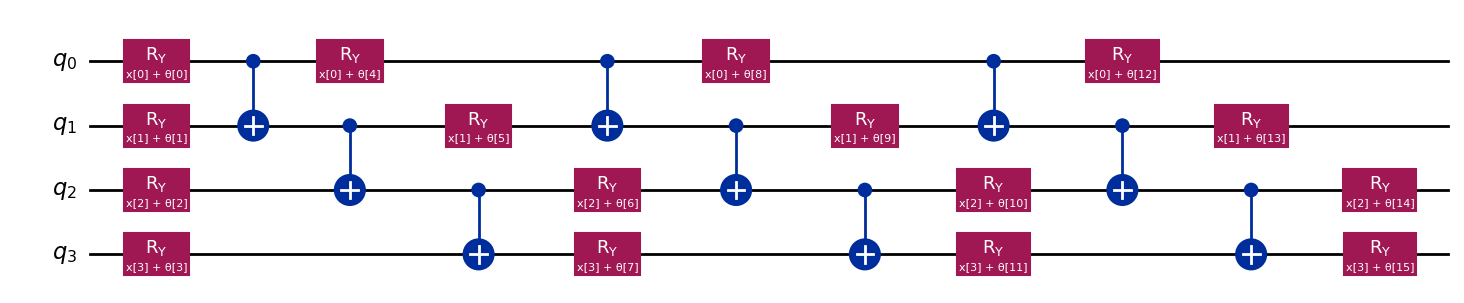

In [70]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def create_parametrized_circuit(num_qubits, depth):
    """
    Create a parametrized quantum circuit with the given number of qubits and depth.
    
    Args:
        num_qubits (int): Number of qubits in the circuit.
        depth (int): Depth of the circuit (number of layers).
        
    Returns:
        QuantumCircuit: A parametrized quantum circuit.
    """

    qc = QuantumCircuit(num_qubits)
    data = ParameterVector('x', length=num_qubits)
    params = ParameterVector('θ', length=num_qubits * depth * 2)

    # Initial layer
    for i in range(num_qubits):
        qc.ry(data[i] + params[i], i)

    params_index = num_qubits
    # Add layers of entangling gates and parametrized gates
    for layer in range(depth):
        # Apply entangling CNOT gates between adjacent qubits
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)

        # Apply a layer of parametrized gates
        for i in range(num_qubits):
            qc.ry(data[i] + params[params_index], i)
            params_index += 1
    
    return qc

# Example usage
parametrized_circuit = create_parametrized_circuit(num_qubits, depth)
parametrized_circuit.draw('mpl')
# -*- coding: utf-8 -*-

## 3. Build A Loss Function

$E(\theta) = 1 - \frac{1}{L} \sum_{j=1}^L \frac{1}{M_j} \sum_{i=1}^{M_j} \left|\langle \psi(x_i^j, \theta) \mid y_j \rangle \right|^2$

In [71]:
from qiskit.quantum_info import Statevector
import numpy as np

def loss_function_E(theta, X_data, y_data, circuit_template, num_classes):
    """
    Compute the loss function as defined in the equation:
    E(theta) = 1 - (1/L) * sum_{j=1}^L (1/M_j) * sum_{i=1}^{M_j} |<psi(x_i^j, theta)|y_j>|^2

    Args:
        theta (np.ndarray): Parameters for the quantum circuit.
        X_data (np.ndarray): Input data, shape (N, num_qubits).
        y_data (np.ndarray): Labels, shape (N,). {-1, 1} for binary classification.
        circuit_template (QuantumCircuit): Parametrized quantum circuit.
        num_classes (int): Number of classes.

    Returns:
        float: Loss value.

        example:
        theta = np.random.rand(8)  # Example parameters for depth=1 and num_qubits=4
        loss = loss_function(theta, X_train, y_train, parametrized_circuit, num_classes=2)
        print(f"Loss: {loss}")

    """

    class_patterns = {0: '00', 1: '01', 2: '10'}
    L = num_classes
    loss = 0.0


    for j in range(L):
        # Select samples of class j
        idx = np.where(y_data == j)[0]
        M_j = len(idx)
        if M_j == 0:
            continue
        class_loss = 0.0
        for i in idx:
            # Bind data and parameters to the circuit
            param_dict = {}
            # Data parameters
            for k in range(X_data.shape[1]):
                param_dict[circuit_template.parameters[k]] = X_data[i, k]
            # Theta parameters
            theta_params = list(circuit_template.parameters)[X_data.shape[1]:]
            for k, t in enumerate(theta):
                param_dict[theta_params[k]] = t
            # Get statevector
            psi = Statevector.from_instruction(circuit_template.assign_parameters(param_dict))

            #=================================================================#
            prob = 0.0
            pattern = class_patterns[j]
            remaining_qubits = X_data.shape[1] - 2
            # Sum over all possible states for the remaining qubits
            for state_idx in range(2**remaining_qubits):
                # Create full basis state string
                remaining_bits = format(state_idx, f'0{remaining_qubits}b')
                full_state = pattern + remaining_bits
                
                # Create basis state and compute probability
                y_j = Statevector.from_label(full_state)
                prob += np.abs(np.vdot(psi.data, y_j.data))**2
            #================================================================#

            class_loss += prob
        loss += class_loss / M_j
    loss = 1 - (loss / L)
    return loss


# Example usage
theta_example = np.random.rand(len(parametrized_circuit.parameters) - num_qubits) 
loss_example = loss_function_E(theta_example, X_train, y_train, parametrized_circuit, num_classes= num_classes)
print(f"Loss: {loss_example}")


Loss: 0.7567641951998526


## 4. Build a optimize function
- COBYLA

In [72]:
from scipy.optimize import minimize

# Create a callback function to monitor optimization progress (optional)
loss_history = []
def callback(theta):
    current_loss = loss_function_E(theta, X_train, y_train, parametrized_circuit, num_classes)
    loss_history.append(current_loss)
    print(f"Loss at iteration {len(loss_history)}: {current_loss}")
    return loss_history


# Create a loss function for the quantum circuit
def optimize_cobyla(loss_func, theta_init, X_data, y_data, circuit_template, callback, num_classes):
    """
    Optimize the loss function using COBYLA.

    Args:
        loss_func (callable): The loss function to minimize.
        theta_init (np.ndarray): Initial parameters.
        X_data (np.ndarray): Training data.
        y_data (np.ndarray): Training labels.
        circuit_template (QuantumCircuit): Parametrized quantum circuit.
        num_classes (int): Number of classes.

    Returns:
        OptimizeResult: The result of the optimization.
    """
    result = minimize(
        loss_func,
        theta_init,
        args=(X_data, y_data, circuit_template, num_classes),
        method='COBYLA',
        options={'maxiter': 100},
        callback=callback
    )
    return result

# Example usage:
print("Starting optimization...")
theta_init = np.zeros(len(parametrized_circuit.parameters) - num_qubits)
result_E = optimize_cobyla(loss_function_E, theta_init, X_train, y_train, parametrized_circuit, callback= callback, num_classes=num_classes)
print("Optimized theta:", result_E.x)
print("Final loss:", result_E.fun)

Starting optimization...
Loss at iteration 1: 0.6924848772078724
Loss at iteration 2: 0.7019279277186878
Loss at iteration 3: 0.7128334508408842
Loss at iteration 4: 0.7890492582523609
Loss at iteration 5: 0.5852220160717125
Loss at iteration 6: 0.7098736486581654
Loss at iteration 7: 0.6308291156542214
Loss at iteration 8: 0.5900715083827233
Loss at iteration 9: 0.6431942072425769
Loss at iteration 10: 0.6541945041216142
Loss at iteration 11: 0.6433379485642687
Loss at iteration 12: 0.6613167719771409
Loss at iteration 13: 0.5852220160717125
Loss at iteration 14: 0.5852220160717128
Loss at iteration 15: 0.6809849407133652
Loss at iteration 16: 0.7376084238497953
Loss at iteration 17: 0.5438123335434091
Loss at iteration 18: 0.5608356446051566
Loss at iteration 19: 0.540441353526701
Loss at iteration 20: 0.6344855998870538
Loss at iteration 21: 0.5595198861772381
Loss at iteration 22: 0.5573269234090188
Loss at iteration 23: 0.52333877439801
Loss at iteration 24: 0.518485199008305
Loss

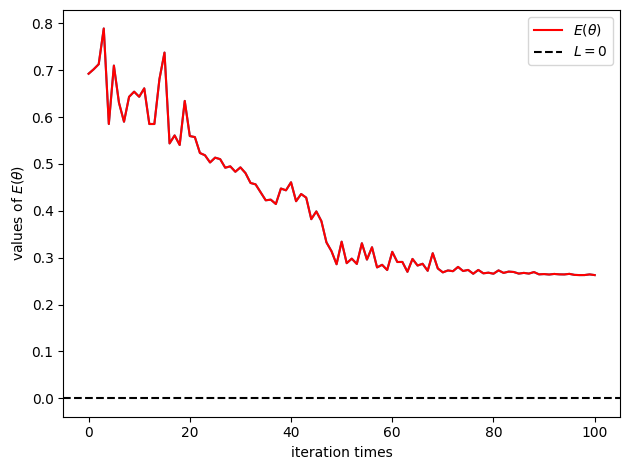

In [73]:
# Plot loss history
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("iteration times")
plt.ylabel(r"values of $E(\theta)$")
plt.plot(loss_history, color='red', label=r"$E(\theta)$")
plt.axhline(0, color='black', linestyle='--', label=r"$L=0$")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Build a function for compute kernel matrix

$$K_{ij} = |<\psi(x_i, \theta)|\psi(x_j, \theta)>|^2$$


In [74]:
def compute_kernel_matrix(X_data, circuit_template, theta_params):
    """
    Compute the kernel matrix K_ij = |<psi(x_i, theta)|psi(x_j, theta)>|^2
    """
    n_samples = X_data.shape[0]
    kernel_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            # Prepare statevector for x_i
            param_dict_i = {}
            for k in range(X_data.shape[1]):
                param_dict_i[circuit_template.parameters[k]] = X_data[i, k]
            theta_params_list = list(circuit_template.parameters)[X_data.shape[1]:]
            for k, t in enumerate(theta_params):
                param_dict_i[theta_params_list[k]] = t
            sv_i = Statevector.from_instruction(circuit_template.assign_parameters(param_dict_i))

            # Prepare statevector for x_j
            param_dict_j = {}
            for k in range(X_data.shape[1]):
                param_dict_j[circuit_template.parameters[k]] = X_data[j, k]
            for k, t in enumerate(theta_params):
                param_dict_j[theta_params_list[k]] = t
            sv_j = Statevector.from_instruction(circuit_template.assign_parameters(param_dict_j))

            # Compute squared overlap
            kernel_matrix[i, j] = np.abs(np.vdot(sv_i.data, sv_j.data))**2
    return kernel_matrix

# Kernel matrix before training
kernel_before = compute_kernel_matrix(X_train, parametrized_circuit, theta_init)

# Kernel matrix after training
kernel_after = compute_kernel_matrix(X_train, parametrized_circuit, result_E.x)

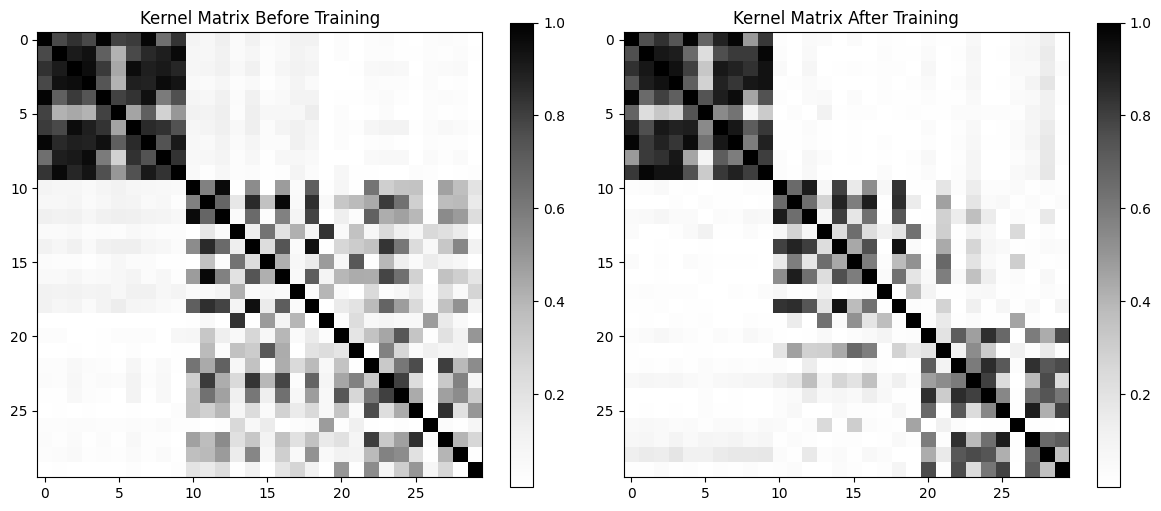

In [75]:
# Plot the kernel matrices
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
im0 = axs[0].imshow(kernel_before, cmap='Greys')
axs[0].set_title("Kernel Matrix Before Training")
plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(kernel_after, cmap='Greys')
axs[1].set_title("Kernel Matrix After Training")
plt.colorbar(im1, ax=axs[1])
plt.tight_layout()
plt.show()
